In [1]:
!pip install --upgrade -q seaborn google-cloud-firestore python-dateutil


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
# Auth:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/tf/credentials.json"

# Data:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dateutil.parser

# Visualization:
import seaborn as sns

# Database:
from google.cloud import firestore

# TF:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


#print(tf.__version__)



In [3]:
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
# Create db instance: 
db = firestore.Client()

## Price helper functions

In [5]:
def get_price_data(id):
    #try:
        #output = pd.read_csv(f'data/price/{id}.csv', index_col='date')
        #output.drop(columns=['Unnamed: 0'], inplace = True)
        #return output
    #except FileNotFoundError:
    doc = db.collection('prices').document(id).get().to_dict()
    
    df = pd.DataFrame.from_dict(doc['priceData'])
    df = add_calculated_columns(df)
    df = convert_dates(df)
    df.to_csv(f'data/price/{id}.csv')

    # Read the file to lazily make sure that the dates are strings etc.
    # FIXME: Should probably be done some other way.
    output = pd.read_csv(f'data/price/{id}.csv', index_col='date')
    output.drop(columns=['Unnamed: 0'], inplace = True)
    return output

def convert_dates(df):
    for i, row in df.iterrows():
        df.at[i,'date'] = dateutil.parser.isoparse(row['date'])
    return df

def add_calculated_columns(price):
    lookbacks = [20, 50, 100, 200]
    
    #zscore = lambda x: (x[-1] - x.mean()) / x.std(ddof=1)
    
    
    for lookback in lookbacks:
        # Get the rolling average and std:
        price['average'] = price['close'].rolling(lookback).mean()
        price['std'] = price['close'].rolling(lookback).std()
        
        # Normalize distance to mean. This could be done with the data above but dont know how.
        price[f'zs-{lookback}'] = (price['close'] - price['average']) / price['std']

        # Get slope of rolling average and std
        price[f'ma-slope-{lookback}'] = price['average'] / price['average'].shift(1)
        price[f'ma-slope-{lookback}'] = price['std'] / price['average'].shift(1)

        # Drop the actual values since they carry no interest:
        price.drop(columns=['average', 'std'], inplace = True)
        
        # TODO: Add min/max[lookback] divided by last close
        # TODO: Add calculations for volume
        # TODO: Add calculations for owners
    return price

    

## Feature Columns

In [6]:
def get_feature_columns(price_data):
    output = price_data.drop(columns=[
        'high',
        'low', 
        'open',
        'close',
        'volume',
        'owners'
    ])
    return output

## Trade Helper functions

This part contains utils functions that will simplify the data creation

In [7]:
def get_trades(doc):
    """
    Converts a trade document into a dataframe of trades
    """

    df = pd.DataFrame.from_dict(doc['trades'])
    for i, row in df.iterrows():
        df.at[i,'result'] = row['exitPrice'] / row['entryPrice']

        try:
            df.at[i,'date'] = row['triggerDate']
        except:
            df.at[i,'date'] = None


    try:
        df.drop(columns=['entryDate', 'exitDate', 'triggerDate'], inplace = True)
    except:
        df.drop(columns=['entryDate', 'exitDate'], inplace = True)

    return df

def get_trade_df(filename):
    """
    Gets all trades and concatenates them into a single dataframe.
    It saves it to disk to avoid having to fetch it multiple times.
    """
    output = pd.DataFrame()
    err = False
    try:
        output = pd.read_csv(filename, index_col='date')
    except FileNotFoundError:
        err = True
    
    if (err == False):
        return output

    docs = db.collection('trades').stream()
    i = 0
    output = pd.DataFrame()
    
    for index, doc in enumerate(docs):
        print(index)
        price = get_price_data(doc.id)
        df = get_trades(doc.to_dict()) 
        # TODO: Convert dates here: source.strftime("%Y-%m-%d %H:%M:%S%z")
        try:
            df.to_csv(f'data/trades/{doc.id}.csv')
            read = pd.read_csv(f'data/trades/{doc.id}.csv', index_col='date')
            test = read.join(get_feature_columns(price))
            output = pd.concat([output, test])
            i = i+1


        except:
            print(doc.id)
            df.to_csv(f'data/trades/{doc.id}.csv')
            print('wrote')
            read = pd.read_csv(f'data/trades/{doc.id}.csv', index_col='date')
            print('read')
            test = read.join(get_feature_columns(price))
            print('join')
            output = pd.concat([output, test])
            print('concat')




    print(f'Found {i} documents, {len(output.index)} trades')
                
    output.to_csv(filename)

    return pd.read_csv(filename, index_col='date')



## Load Trades

In [43]:

trades = get_trade_df('/tf/data/trades/allTrades.csv')
trades.head()

Unnamed: 0 stockName  entryPrice  stockId  \
date                                                                   
2019-11-10 23:00:00+00:00           0       EQT      105.65  1001617   
2020-06-03 22:00:00+00:00           1       EQT      170.50  1001617   
2020-07-05 22:00:00+00:00           2       EQT      184.00  1001617   
2020-10-13 22:00:00+00:00           3       EQT      186.75  1001617   
2009-10-08 22:00:00+00:00           0  Eastnine       68.00   100687   

                           exitPrice            stockList    result     zs-20  \
date                                                                            
2019-11-10 23:00:00+00:00     141.00  Large Cap Stockholm  1.334595  2.406278   
2020-06-03 22:00:00+00:00     147.55  Large Cap Stockholm  0.865396  2.570386   
2020-07-05 22:00:00+00:00     171.50  Large Cap Stockholm  0.932065  2.339982   
2020-10-13 22:00:00+00:00     188.80  Large Cap Stockholm  1.010977  1.817743   
2009-10-08 22:00:00+00:00      74.00    Mid Cap Stockholm  1.088235  2.875387   

                           ma-slope-20     zs-50  ma-slope-50    zs-100  \
date                                                                      
2019-11-10 23:00:00+00:00     0.057286       NaN          NaN       NaN   
2020-06-03 22:00:00+00:00     0.047083  2.138433     0.124310  2.087838   
2020-07-05 22:00:00+00:00     0.053120  2.121880     0.096089  1.999881   
2020-10-13 22:00:00+00:00     0.055957  0.618434     0.112336  0.539262   
2009-10-08 22:00:00+00:00     0.035557  3.192040     0.036429  2.799438   

                           ma-slope-100    zs-200  ma-slope-200  
date                                                             
2019-11-10 23:00:00+00:00           NaN       NaN           NaN  
2020-06-03 22:00:00+00:00      0.135202       NaN           NaN  
2020-07-05 22:00:00+00:00      0.154610       NaN           NaN  
2020-10-13 22:00:00+00:00      0.117465  1.146368      0.200314  
2009-10-08 22:00:00+00:00      0.040015  1.646123      0.159546

In [44]:
# Check for invalid values:
trades.isna().sum()

Unnamed: 0        0
stockName         0
entryPrice        0
stockId           0
exitPrice         0
stockList         0
result            0
zs-20            57
ma-slope-20      60
zs-50           125
ma-slope-50     125
zs-100          192
ma-slope-100    193
zs-200          342
ma-slope-200    344
dtype: int64

In [45]:
# Drop invalid values
trades = trades.dropna()


In [46]:
# Remove the date as index column since its not unique:
trades.reset_index(inplace = True, drop = True) 
trades.drop(columns=['Unnamed: 0', 'stockName', 'stockList', 'entryPrice', 'exitPrice', 'stockId'], inplace=True)
train_dataset = trades.sample(frac=0.8, random_state=0)
test_dataset = trades.drop(train_dataset.index)


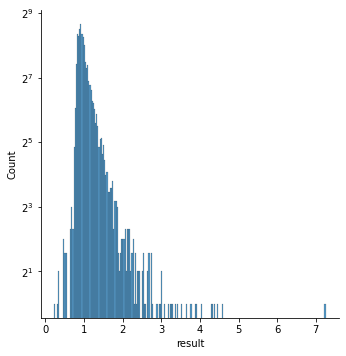

In [47]:
g = sns.displot(train_dataset, x="result")
g.fig.get_axes()[0].set_yscale('log', base=2)

In [48]:
train_dataset['result'].describe()
# Note that Mean > Median, indicating that the winrate is high enough 
# to get a profit even though its losing more than winning.

count    4177.000000
mean        1.063097
std         0.341572
min         0.232558
25%         0.887681
50%         0.972222
75%         1.124744
max         7.250048
Name: result, dtype: float64

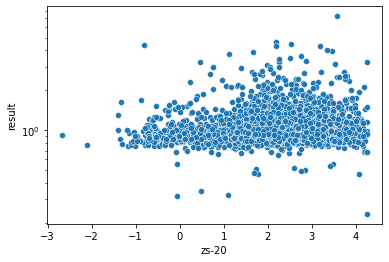

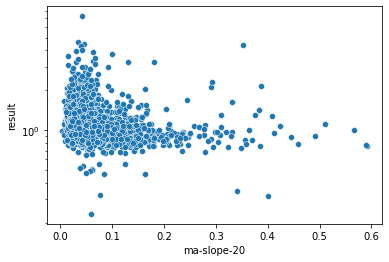

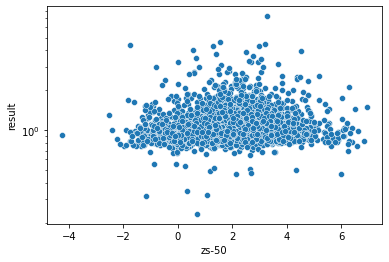

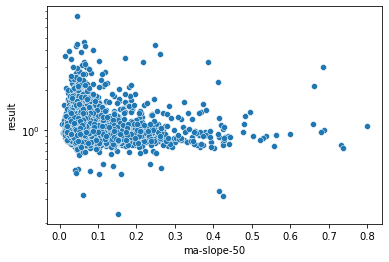

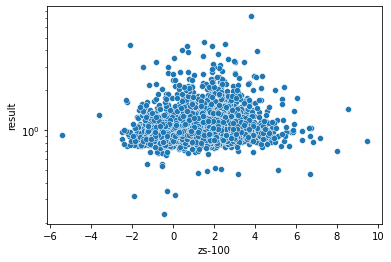

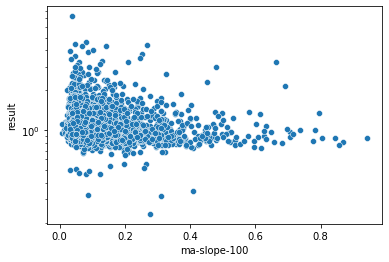

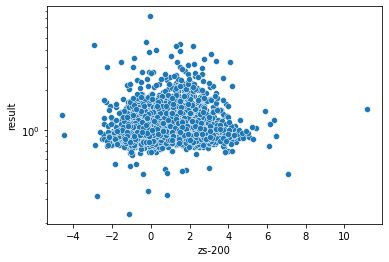

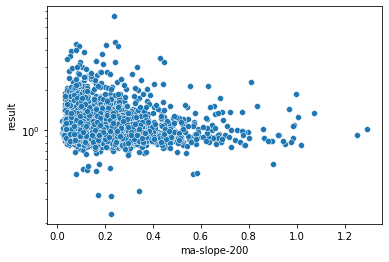

In [49]:
chartColumns = [
    'zs-20',
    'ma-slope-20',
    'zs-50',
    'ma-slope-50',
    'zs-100',
    'ma-slope-100',
    'zs-200',
    'ma-slope-200'
]

for col in chartColumns:
    g = sns.scatterplot(data=train_dataset, x=col, y="result")
    g.set(yscale="log")
    plt.show()


In [50]:
# Splut features from labels:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('result')
test_labels = test_features.pop('result')



## Data normalization:

In [51]:
train_features.head()

zs-20  ma-slope-20     zs-50  ma-slope-50    zs-100  ma-slope-100  \
4415  1.749306     0.012491  1.073709     0.065602  1.551811      0.062811   
1803  1.778617     0.055913  1.998532     0.120566  2.854368      0.110411   
3296  2.511676     0.058327  1.090637     0.074875  0.208974      0.092409   
3953  2.557764     0.058133  2.232911     0.060196  0.926318      0.104261   
3156  2.191618     0.042091  3.131325     0.037003  3.482423      0.041480   

        zs-200  ma-slope-200  
4415  2.078451      0.078446  
1803  3.611046      0.107552  
3296  0.054132      0.156443  
3953 -0.404293      0.273760  
3156  1.956734      0.132452

In [52]:
data = np.array([[0.1, 0.2, 0.3], [0.8, 0.9, 1.0], [1.5, 1.6, 1.7],])

print(np.array(data))
#print(np.array())

normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features.head()))
print(normalizer.mean.numpy())


[[0.1 0.2 0.3]
 [0.8 0.9 1. ]
 [1.5 1.6 1.7]]
[2.158 0.045 1.905 0.072 1.805 0.082 1.459 0.15 ]


In [53]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[1.75 0.01 1.07 0.07 1.55 0.06 2.08 0.08]]

Normalized: [[-1.18 -1.88 -1.08 -0.22 -0.21 -0.74  0.42 -1.06]]


## Linear regression

In [54]:
zs100_lin_reg = np.array(train_features['zs-100'])

zs100_normalizer = preprocessing.Normalization(input_shape=[1,])
zs100_normalizer.adapt(zs100_lin_reg)



In [55]:
# Build the model
zs100_lin_reg_model = tf.keras.Sequential([
    zs100_normalizer,
    layers.Dense(units=1)
])

zs100_lin_reg_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_10 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [75]:
zs100_lin_reg_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [76]:
%%time
history = zs100_lin_reg_model.fit(
    train_features['zs-100'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


CPU times: user 9.94 s, sys: 1.48 s, total: 11.4 s
Wall time: 8.78 s


In [77]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


loss  val_loss  epoch
95  0.192061  0.196228     95
96  0.194227  0.182606     96
97  0.187392  0.178915     97
98  0.196722  0.210076     98
99  0.191000  0.182914     99

In [86]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Result]')
  plt.legend()
  plt.grid(True)
  plt.show()


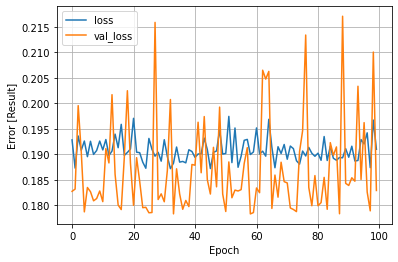

In [79]:
plot_loss(history)


Collect test results for later:

In [80]:
test_results = {}

test_results['zs-100_linear_regression'] = zs100_lin_reg_model.evaluate(
    test_features['zs-100'],
    test_labels, verbose=0)


Plot the linear regression:

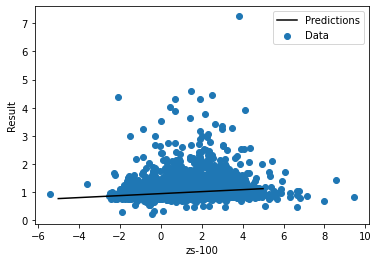

In [109]:
x = tf.linspace(-5, 5, 251)
y = zs100_lin_reg_model.predict(x)

def plot_zs100(x, y):
  plt.scatter(train_features['zs-100'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('zs-100')
  plt.ylabel('Result')
  plt.legend()

plot_zs100(x,y)


## Linear model

In [143]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])


array([[ 1.684],
       [ 1.66 ],
       [-1.974],
       [-2.333],
       [ 0.963],
       [-2.171],
       [-2.31 ],
       [ 1.383],
       [ 0.982],
       [-1.817]], dtype=float32)

In [158]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')


In [159]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


CPU times: user 10.5 s, sys: 1.66 s, total: 12.1 s
Wall time: 9.24 s


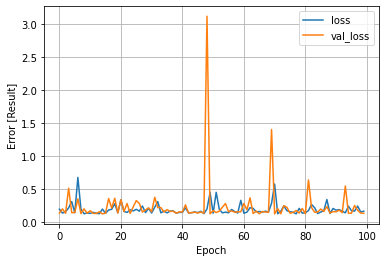

In [160]:
plot_loss(history)
# Complete junk

## DNN regression

In [161]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(16, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Single variable

In [162]:
dnn_zs100_model = build_and_compile_model(zs100_normalizer)
dnn_zs100_model.summary()



Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_10 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_38 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17        
Total params: 324
Trainable params: 321
Non-trainable params: 3
_________________________________________________________________


In [163]:
%%time
history = dnn_zs100_model.fit(
    train_features['zs-100'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)


CPU times: user 12.1 s, sys: 1.49 s, total: 13.6 s
Wall time: 10.3 s


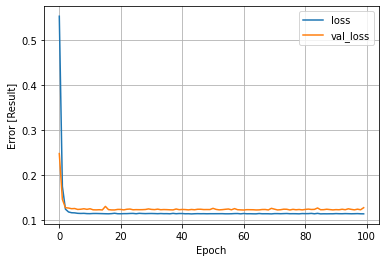

In [164]:
plot_loss(history)


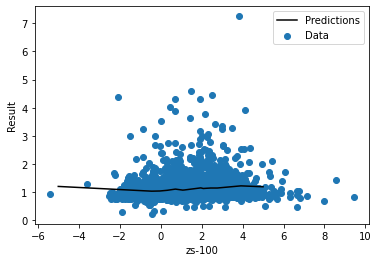

In [165]:
x = tf.linspace(-5, 5, 251)
y = dnn_zs100_model.predict(x)
plot_zs100(x, y)


In [166]:
# Save the results:
test_results['dnn_zs100_model'] = dnn_zs100_model.evaluate(
    test_features['zs-100'], test_labels,
    verbose=0)


### Full model:

In [167]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 8)                 17        
_________________________________________________________________
dense_40 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_41 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 17        
Total params: 450
Trainable params: 433
Non-trainable params: 17
_________________________________________________________________


In [168]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)


CPU times: user 11.6 s, sys: 1.45 s, total: 13 s
Wall time: 9.75 s


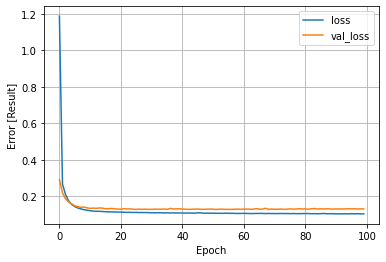

In [169]:
plot_loss(history)

In [170]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)


In [172]:
pd.DataFrame(test_results, index=['Mean squared error [result]']).T

Mean squared error [result]
zs-100_linear_regression                     0.182152
dnn_zs100_model                              0.110769
dnn_model                                    0.117141

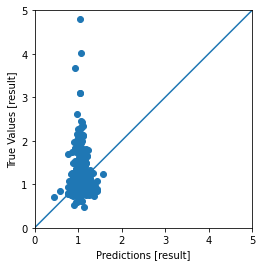

In [178]:
test_predictions = dnn_model.predict(test_features)

a = plt.axes(aspect='equal')
plt.scatter(test_predictions.flatten(), test_labels)
plt.ylabel('True Values [result]')
plt.xlabel('Predictions [result]')
lims = [0, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


In [239]:
def sumarize_trades(df):    
    winning = df[df['actual'] >= 1]
    losing = df[df['actual'] < 1]
   
    winners = len(winning)
    losers = len(losing)
    winrate = winners / (winners+losers)
    total_win = winning['res'].sum()
    total_loss = losing['res'].sum()
    avg_win = total_win / winners
    avg_loss = total_loss / losers
  
    return pd.DataFrame({'count': len(df), 
                        'winners': winners,
                        'losers': losers,
                        'total_win': total_win,
                        'total_loss': total_loss,
                        'avg_win': avg_win,
                        'avg_loss': avg_loss,
                        'winrate': winrate,
                        'profit_factor': total_win/-total_loss
                        }, index=[0])


In [247]:
pred_series = pd.Series(test_predictions.flatten())
actual_series = pd.Series(test_labels)


res = pd.DataFrame({'predicted': test_predictions.flatten(), 'actual': test_labels})
for i, row in res.iterrows():
    res.at[i,'res'] = row['actual'] - 1

predicted_winners = res[res['predicted'] >= 1]
predicted_losers = res[res['predicted'] < 1]

df = pd.DataFrame()

df = df.append(sumarize_trades(res))
df = df.append(sumarize_trades(predicted_winners))
df = df.append(sumarize_trades(predicted_losers))

df.head()


count  winners  losers   total_win  total_loss   avg_win  avg_loss  \
0   1044      450     594  126.091416  -65.697265  0.280203 -0.110601   
0    760      341     419   92.498913  -43.978359  0.271258 -0.104960   
0    284      109     175   33.592502  -21.718906  0.308188 -0.124108   

    winrate  profit_factor  
0  0.431034       1.919280  
0  0.448684       2.103283  
0  0.383803       1.546694

In [243]:
predicted_winners.describe()

predicted      actual         res
count  760.000000  760.000000  760.000000
mean     1.087969    1.063843    0.063843
std      0.074411    0.328724    0.328724
min      1.000295    0.488417   -0.511583
25%      1.036893    0.892197   -0.107803
50%      1.071037    0.973242   -0.026758
75%      1.115549    1.126276    0.126276
max      1.576955    4.795088    3.795088

In [244]:
predicted_losers.describe()

predicted      actual         res
count  284.000000  284.000000  284.000000
mean     0.943933    1.041808    0.041808
std      0.059854    0.331507    0.331507
min      0.456811    0.531915   -0.468085
25%      0.921897    0.854780   -0.145220
50%      0.962297    0.941304   -0.058696
75%      0.985097    1.096429    0.096429
max      0.999820    3.680508    2.680508


## Features
- Avg volume
- STD
- 1,3,6,12m perf
- 1,3,6,12m relative perf (mot index)
- räntekurva
- breadth
- rsi, massa olika
- high massa olika
- low massa olika
- range massa olika
- Insiderköp
- nyheter

